In [11]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [5]:
# def ellipse_func(params, data):
#     a, b, c, d, e, f = params
#     x, y, z = data.T
#     return (a*x**2 + b*x*y + c*y**2 + d*x + e*y + f)

def ellipse_func(params, data):
    a, b, c, d, e, f = params
    x, y, z = data.T
    return sum(a*x**2 + b*x*y + c*y**2 + d*x + e*y + f)


def fit_ellipse(data):
    x, y, z = data.T
    initial_guess = (1, 1, 1, 0, 0, 0)
    res = minimize(ellipse_func, initial_guess, args=(data,), method='BFGS')
    a, b, c, d, e, f = res.x
    return a, b, c, d, e, f

In [6]:
data = np.random.rand(50, 3)
a, b, c, d, e, f = fit_ellipse(data)

In [7]:
a

-20078309.453114334

<IPython.core.display.Javascript object>


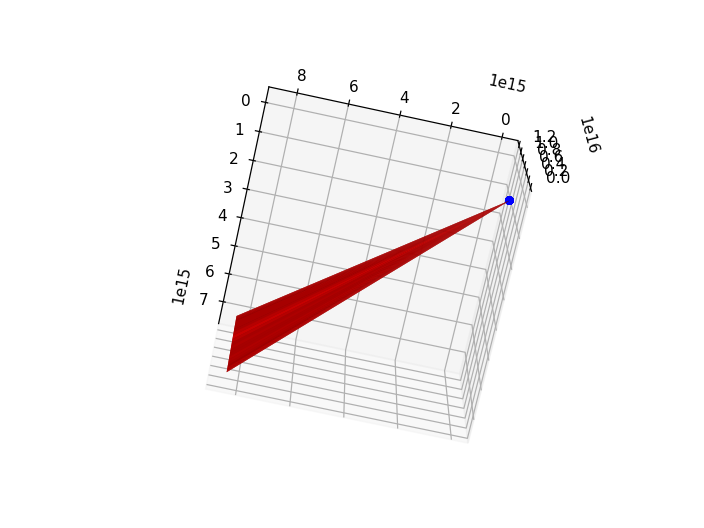

<ipython-input-12-5eb517684c43>:10: RuntimeWarning: divide by zero encountered in true_divide
  x = (a*np.outer(np.cos(u), np.sin(v)) + d*np.cos(u))/(-b*np.sin(u))
<ipython-input-12-5eb517684c43>:11: RuntimeWarning: divide by zero encountered in true_divide
  y = (c*np.outer(np.cos(u), np.sin(v)) + e*np.cos(u))/(-b*np.sin(u))
<ipython-input-12-5eb517684c43>:12: RuntimeWarning: divide by zero encountered in true_divide
  z = (f + a*np.outer(np.cos(u), np.sin(v)) + b*np.outer(np.sin(u), np.sin(v)) + c*np.outer(np.cos(u), np.cos(v)) + d*np.sin(u) + e*np.cos(v))/(-b*np.sin(u))


In [12]:
# Plot the data points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], color='b')

# Plot the ellipse
a, b, c, d, e, f = fit_ellipse(data)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = (a*np.outer(np.cos(u), np.sin(v)) + d*np.cos(u))/(-b*np.sin(u))
y = (c*np.outer(np.cos(u), np.sin(v)) + e*np.cos(u))/(-b*np.sin(u))
z = (f + a*np.outer(np.cos(u), np.sin(v)) + b*np.outer(np.sin(u), np.sin(v)) + c*np.outer(np.cos(u), np.cos(v)) + d*np.sin(u) + e*np.cos(v))/(-b*np.sin(u))
ax.plot_surface(x, y, z, color='r')

plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fit_ellipsoid(data):
    # Compute the centroid of the data points
    centroid = np.mean(data, axis=0)
    
    # Center the data points
    centered_data = data - centroid
    
    # Compute the covariance matrix of the centered data points
    covariance_matrix = np.cov(centered_data.T)
    
    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    return centroid, eigenvalues, eigenvectors

def plot_ellipsoid(centroid, eigenvalues, eigenvectors, data):
    # Define the ellipsoid equation
    a, b, c = eigenvalues
    v1, v2, v3 = eigenvectors
    x, y, z = data.T
    x0, y0, z0 = centroid
    u = np.linspace(x.min(), x.max(), 100)
    v = np.linspace(y.min(), y.max(), 100)
    X,Y = np.meshgrid(u,v)
    Z = ((X-x0)**2/a + (Y-y0)**2/b + (z-z0)**2/c)
#     Z = Z.reshape(100, 100)
    #Z = ((X-x0)**2/a + (Y-y0)**2/b + (np.repeat(z,10*10)-z0)**2/c)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], color='b')
    ax.plot_surface(X, Y, Z, alpha=0.2)
    plt.show()    
data = np.random.rand(50, 3)
centroid, eigenvalues, eigenvectors = fit_ellipsoid(data)
plot_ellipsoid(centroid, eigenvalues, eigenvectors, data)

ValueError: operands could not be broadcast together with shapes (100,100) (50,) 

In [29]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from numpy.linalg import eig, inv

def ls_ellipsoid(xx,yy,zz):                                  
    #finds best fit ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    #least squares fit to a 3D-ellipsoid
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
    #
    # Note that sometimes it is expressed as a solution to
    #  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
    # where the last six terms have a factor of 2 in them
    # This is in anticipation of forming a matrix with the polynomial coefficients.
    # Those terms with factors of 2 are all off diagonal elements.  These contribute
    # two terms when multiplied out (symmetric) so would need to be divided by two
    
    # change xx from vector of length N to Nx1 matrix so we can use hstack
    x = xx[:,np.newaxis]
    y = yy[:,np.newaxis]
    z = zz[:,np.newaxis]
    
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
    J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
    K = np.ones_like(x) #column of ones
    
    #np.hstack performs a loop over all samples and creates
    #a row in J for each x,y,z sample:
    # J[ix,0] = x[ix]*x[ix]
    # J[ix,1] = y[ix]*y[ix]
    # etc.
    
    JT=J.transpose()
    JTJ = np.dot(JT,J)
    InvJTJ=np.linalg.inv(JTJ);
    ABC= np.dot(InvJTJ, np.dot(JT,K))

    # Rearrange, move the 1 to the other side
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
    #    or
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
    #  where J = -1
    eansa=np.append(ABC,-1)

    return (eansa)

def polyToParams3D(vec,printMe):                             
    #gets 3D parameters of an ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    # convert the polynomial form of the 3D-ellipsoid to parameters
    # center, axes, and transformation matrix
    # vec is the vector whose elements are the polynomial
    # coefficients A..J
    # returns (center, axes, rotation matrix)
    
    #Algebraic form: X.T * Amat * X --> polynomial form
    
    if printMe: print('\npolynomial\n',vec)
    
    Amat=np.array(
    [
    [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
    [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
    [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
    [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
    ])
    
    if printMe: print('\nAlgebraic form of polynomial\n',Amat)
    
    #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
    # equation 20 for the following method for finding the center
    A3=Amat[0:3,0:3]
    A3inv=inv(A3)
    ofs=vec[6:9]/2.0
    center=-np.dot(A3inv,ofs)
    if printMe: print('\nCenter at:',center)
    
    # Center the ellipsoid at the origin
    Tofs=np.eye(4)
    Tofs[3,0:3]=center
    R = np.dot(Tofs,np.dot(Amat,Tofs.T))
    if printMe: print('\nAlgebraic form translated to center\n',R,'\n')
    
    R3=R[0:3,0:3]
    R3test=R3/R3[0,0]
    # print('normed \n',R3test)
    s1=-R[3, 3]
    R3S=R3/s1
    (el,ec)=eig(R3S)
    
    recip=1.0/np.abs(el)
    axes=np.sqrt(recip)
    if printMe: print('\nAxes are\n',axes  ,'\n')
    
    inve=inv(ec) #inverse is actually the transpose here
    if printMe: print('\nRotation matrix\n',inve)
    return (center,axes,inve)


#let us assume some definition of x, y and z

#get convex hull
surface  = np.stack((conf.x,conf.y,conf.z), axis=-1)
hullV    = ConvexHull(surface)
lH       = len(hullV.vertices)
hull     = np.zeros((lH,3))
for i in range(len(hullV.vertices)):
    hull[i] = surface[hullV.vertices[i]]
hull     = np.transpose(hull)         
            
#fit ellipsoid on convex hull
eansa            = ls_ellipsoid(hull[0],hull[1],hull[2]) #get ellipsoid polynomial coefficients
print("coefficients:"  , eansa)
center,axes,inve = polyToParams3D(eansa,False)   #get ellipsoid 3D parameters
print("center:"        , center)
print("axes:"          , axes)
print("rotationMatrix:", inve)

NameError: name 'conf' is not defined

In [43]:
import numpy as np
from scipy.optimize import least_squares

# Generate some sample data
#np.random.seed(0)
data = np.random.randn(100000, 3)

# Define the function for fitting an ellipsoid to the data
def fit_ellipsoid(params, data):
    A, B, C, D, E, F, G, H, I = params[:9]
    x, y, z = data.T
    return (A*x**2 + B*y**2 + C*z**2 + D*x*y + E*x*z + F*y*z + G*x + H*y + I*z)

# Define the function for calculating the residuals
def ellipsoid_residuals(params, data):
    return fit_ellipsoid(params, data) - 1

# Initial guess for the parameters
x0 = np.ones(9)

# Fit the ellipsoid to the data
res = least_squares(ellipsoid_residuals, x0, args=(data,))

# Print the result
print(res.x)

[ 0.19959642  0.19918065  0.20255035 -0.00214704  0.00253229  0.00345298
  0.00167189  0.00091408 -0.0038114 ]


<IPython.core.display.Javascript object>


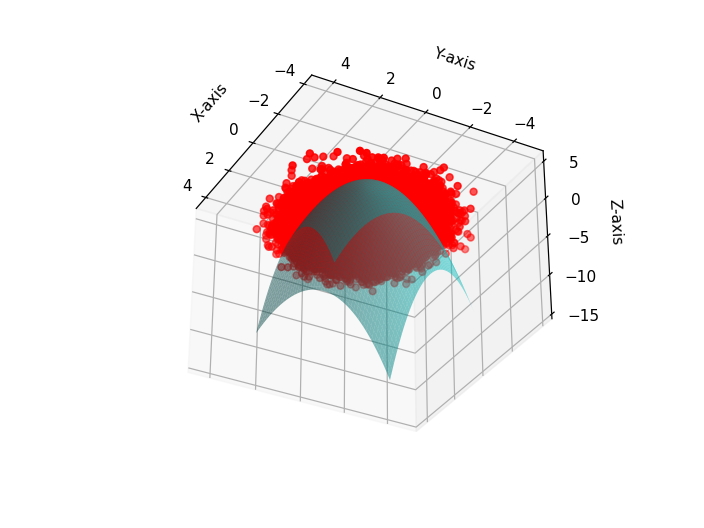

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the optimized parameters
A, B, C, D, E, F, G, H, I = res.x[:9]

# Create a grid of points for plotting the ellipsoid
x, y = np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = (1 - A*X**2 - B*Y**2 - D*X*Y - G*X - H*Y) / (C + E*X + F*Y + I)

# Plot the data and the fitted ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', marker='o')
ax.plot_surface(X, Y, Z, color='c', alpha=0.5)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

In [109]:
import numpy as np
np.random.seed(42)

# Function to generate a random point on a uniform sphere
# (relying on https://stackoverflow.com/a/33977530/8565438)

def randompoint(ndim=3):
    vec = np.random.randn(ndim,1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

# Give the length of each axis (example values):

a, b, c = 1, 2, 4

# Function to scale up generated points using the function `f` mentioned above:

f = lambda x,y,z : np.multiply(np.array([a,b,c]),np.array([x,y,z]))

# Keep the point with probability `mu(x,y,z)/mu_max`, ie

def keep(x, y, z, a=a, b=b, c=c):
    mu_xyz = ((a * c * y) ** 2 + (a * b * z) ** 2 + (b * c * x) ** 2) ** 0.5
    return mu_xyz / (b * c) > np.random.uniform(low=0.0, high=1.0)

# Generate points until we have, let's say, 1000 points:

n = 10000
points = []
while len(points) < n:
    [x], [y], [z] = randompoint()
    if keep(x, y, z):
        points.append(f(x, y, z))

In [110]:
for p in points:
    pscaled = np.multiply(p,np.array([1/a,1/b,1/c]))
    assert np.allclose(np.sum(np.dot(pscaled,pscaled)),1)

In [111]:
print (points)

[array([ 0.60000205, -0.3340306 ,  3.12948158]), array([0.82372582, 0.30183718, 2.18613581]), array([-0.54965384,  1.27044295, -2.170251  ]), array([-0.16522389, -1.85367377,  1.34862569]), array([-0.72547347,  0.4501799 , -2.60160798]), array([-0.85194395, -0.75943635,  1.44225165]), array([-0.42594389,  0.17357935, -3.60230893]), array([ 0.31762535, -1.01494196,  3.20396589]), array([-0.30894685,  1.90210811, -0.02772065]), array([-0.91957743, -0.39896999,  1.354005  ]), array([-0.4083728 , -1.52796035, -1.99826305]), array([ 0.38419988, -0.91302613, -3.20995021]), array([-0.87991607, -0.64841577,  1.38931329]), array([ 0.90903225, -0.33122861, -1.52961314]), array([ 0.51339683,  1.71388851, -0.18199923]), array([0.62396161, 1.20990931, 1.9786936 ]), array([-0.01173996,  1.02544715, -3.4338939 ]), array([ 0.42301164, -1.46038721,  2.14617224]), array([-0.14299555,  0.46492531,  3.84814425]), array([-0.73601784, -0.60259913, -2.42485897]), array([-0.80851338, -0.75469856, -1.80627187]

<IPython.core.display.Javascript object>


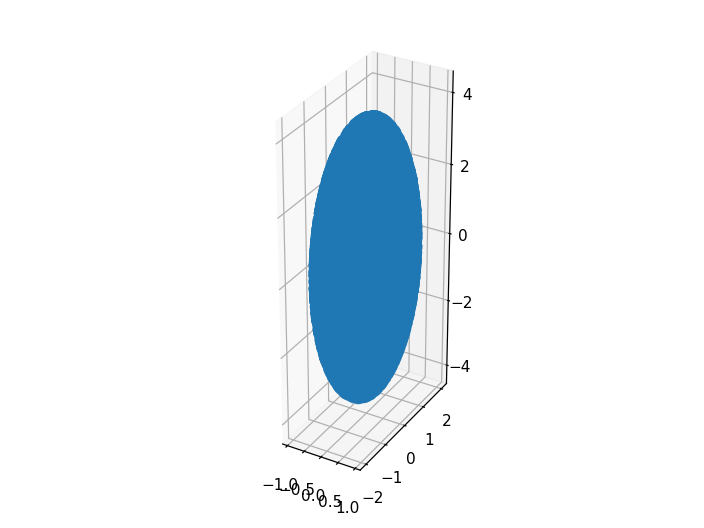

In [112]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
points = np.array(points)
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# set aspect ratio for the axes using https://stackoverflow.com/a/64453375/8565438
ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2])))
plt.show()

In [113]:
import numpy as np
from scipy.optimize import least_squares

# Generate some sample data
#np.random.seed(0)
data = points

# Define the function for fitting an ellipsoid to the data
def fit_ellipsoid(params, data):
    A, B, C, D, E, F, G, H, I = params[:9]
    x, y, z = data.T
    return (A*x**2 + B*y**2 + C*z**2 + D*x*y + E*x*z + F*y*z + G*x + H*y + I*z)

# Define the function for calculating the residuals
def ellipsoid_residuals(params, data):
    return fit_ellipsoid(params, data) - 1

# Initial guess for the parameters
x0 = np.ones(9)

# Fit the ellipsoid to the data
res = least_squares(ellipsoid_residuals, x0, args=(data,))

# Print the result
print(res.x)

[ 1.00000000e+00  2.50000000e-01  6.25000000e-02 -1.40881721e-18
 -2.20269884e-18 -1.15291234e-18  2.09472323e-19  1.56463260e-18
 -3.14228709e-18]


<IPython.core.display.Javascript object>


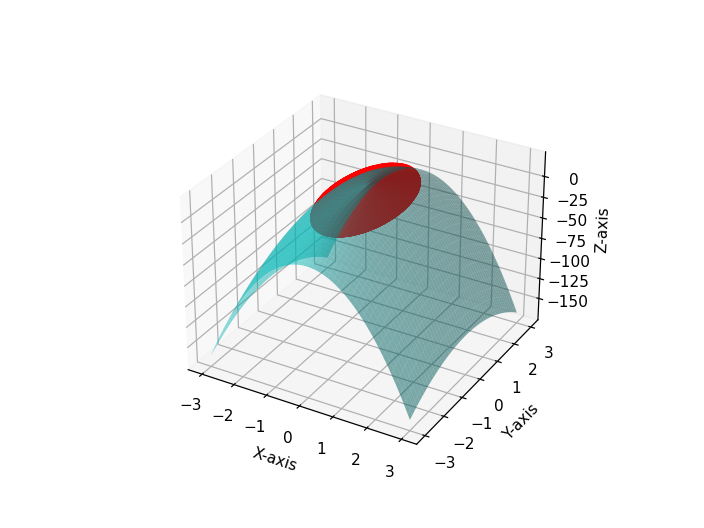

In [114]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the optimized parameters
A, B, C, D, E, F, G, H, I = res.x[:9]

# Create a grid of points for plotting the ellipsoid
x, y = np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = (1 - A*X**2 - B*Y**2 - D*X*Y - G*X - H*Y) / (C + E*X + F*Y + I)

# Plot the data and the fitted ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', marker='o')
ax.plot_surface(X, Y, Z, color='c', alpha=0.5)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

In [115]:
import numpy as np
from numpy.linalg import eig, inv

#least squares fit to a 3D-ellipsoid
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
#
# Note that sometimes it is expressed as a solution to
#  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
# where the last six terms have a factor of 2 in them
# This is in anticipation of forming a matrix with the polynomial coefficients.
# Those terms with factors of 2 are all off diagonal elements.  These contribute
# two terms when multiplied out (symmetric) so would need to be divided by two

def ls_ellipsoid(xx,yy,zz):

   # change xx from vector of length N to Nx1 matrix so we can use hstack
   x = xx[:,np.newaxis]
   y = yy[:,np.newaxis]
   z = zz[:,np.newaxis]

   #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
   J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
   K = np.ones_like(x) #column of ones

   #np.hstack performs a loop over all samples and creates
   #a row in J for each x,y,z sample:
   # J[ix,0] = x[ix]*x[ix]
   # J[ix,1] = y[ix]*y[ix]
   # etc.

   JT=J.transpose()
   JTJ = np.dot(JT,J)
   InvJTJ=np.linalg.inv(JTJ);
   ABC= np.dot(InvJTJ, np.dot(JT,K))

# Rearrange, move the 1 to the other side
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
#    or
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
#  where J = -1
   eansa=np.append(ABC,-1)

   return (eansa)

def polyToParams3D(vec,printMe):

   # convert the polynomial form of the 3D-ellipsoid to parameters
   # center, axes, and transformation matrix
   # vec is the vector whose elements are the polynomial
   # coefficients A..J
   # returns (center, axes, rotation matrix)

   #Algebraic form: X.T * Amat * X --> polynomial form

   if printMe: print ('\npolynomial\n',vec)

   Amat=np.array(
   [
   [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
   [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
   [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
   [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
   ])

   if printMe: print ('\nAlgebraic form of polynomial\n',Amat)

   #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
   # equation 20 for the following method for finding the center
   A3=Amat[0:3,0:3]
   A3inv=inv(A3)
   ofs=vec[6:9]/2.0
   center=-np.dot(A3inv,ofs)
   if printMe: print ('\nCenter at:',center)

   # Center the ellipsoid at the origin
   Tofs=np.eye(4)
   Tofs[3,0:3]=center
   R = np.dot(Tofs,np.dot(Amat,Tofs.T))
   if printMe: print ('\nAlgebraic form translated to center\n',R,'\n')

   R3=R[0:3,0:3]
   R3test=R3/R3[0,0]
   print ('normed \n',R3test)
   s1=-R[3, 3]
   R3S=R3/s1
   (el,ec)=eig(R3S)

   recip=1.0/np.abs(el)
   axes=np.sqrt(recip)
   if printMe: print ('\nAxes are\n',axes  ,'\n')

   inve=inv(ec) #inverse is actually the transpose here
   if printMe: print ('\nRotation matrix\n',inve)
   return (center,axes,inve)

def printAns3D(center,axes,R,xin,yin,zin,verbose):

      print ("\nCenter at  %10.4f,%10.4f,%10.4f" % (center[0],center[1],center[2]))
      print ("Axes gains %10.4f,%10.4f,%10.4f " % (axes[0],axes[1],axes[2]))
      print ("Rotation Matrix\n%10.5f,%10.5f,%10.5f\n%10.5f,%10.5f,%10.5f\n%10.5f,%10.5f,%10.5f" % (
      R[0,0],R[0,1],R[0,2],R[1,0],R[1,1],R[1,2],R[2,0],R[2,1],R[2,2]))


      # Check solution
      # Convert to unit sphere centered at origin
      #  1) Subtract off center
      #  2) Rotate points so bulges are aligned with axes (no xy,xz,yz terms)
      #  3) Scale the points by the inverse of the axes gains
      #  4) Back rotate
      # Rotations and gains are collected into single transformation matrix M

      # subtract the offset so ellipsoid is centered at origin
      xc=xin-center[0]
      yc=yin-center[1]
      zc=zin-center[2]

      # create transformation matrix
      L = np.diag([1/axes[0],1/axes[1],1/axes[2]])
      M=np.dot(R.T,np.dot(L,R))
      print ('\nTransformation Matrix\n',M)

      # apply the transformation matrix
      [xm,ym,zm]=np.dot(M,[xc,yc,zc])
      # Calculate distance from origin for each point (ideal = 1.0)
      rm = np.sqrt(xm*xm + ym*ym + zm*zm)

      print ("\nAverage Radius  %10.4f (truth is 1.0)" % (np.mean(rm)))
      print ("Stdev of Radius %10.4f\n " % (np.std(rm)))

      return

In [116]:
print (points[:,0])

[ 0.60000205  0.82372582 -0.54965384 ... -0.96477246 -0.22210487
  0.78906459]


In [117]:
eansa = ls_ellipsoid(points[:, 0], points[:, 1], points[:, 2])

In [118]:
eansa

array([ 1.00000000e+00,  2.50000000e-01,  6.25000000e-02,  6.93889390e-18,
        1.99493200e-17,  1.30104261e-18,  2.77555756e-17, -6.93889390e-18,
       -1.17093835e-17, -1.00000000e+00])

In [119]:
x = polyToParams3D(eansa,'printMe')


polynomial
 [ 1.00000000e+00  2.50000000e-01  6.25000000e-02  6.93889390e-18
  1.99493200e-17  1.30104261e-18  2.77555756e-17 -6.93889390e-18
 -1.17093835e-17 -1.00000000e+00]

Algebraic form of polynomial
 [[ 1.00000000e+00  3.46944695e-18  9.97465999e-18  1.38777878e-17]
 [ 3.46944695e-18  2.50000000e-01  6.50521303e-19 -3.46944695e-18]
 [ 9.97465999e-18  6.50521303e-19  6.25000000e-02 -5.85469173e-18]
 [ 1.38777878e-17 -3.46944695e-18 -5.85469173e-18 -1.00000000e+00]]

Center at: [-1.38777878e-17  1.38777878e-17  9.36750677e-17]

Algebraic form translated to center
 [[ 1.00000000e+00  3.46944695e-18  9.97465999e-18  1.54074396e-33]
 [ 3.46944695e-18  2.50000000e-01  6.50521303e-19  0.00000000e+00]
 [ 9.97465999e-18  6.50521303e-19  6.25000000e-02  0.00000000e+00]
 [ 1.54074396e-33  0.00000000e+00  0.00000000e+00 -1.00000000e+00]] 

normed 
 [[1.00000000e+00 3.46944695e-18 9.97465999e-18]
 [3.46944695e-18 2.50000000e-01 6.50521303e-19]
 [9.97465999e-18 6.50521303e-19 6.25000000e-02]

In [120]:
print("coefficients:"  , eansa)
center,axes,inve = polyToParams3D(eansa,False)   #get ellipsoid 3D parameters
print("center:"        , center)
print("axes:"          , axes)
print("rotationMatrix:", inve)

coefficients: [ 1.00000000e+00  2.50000000e-01  6.25000000e-02  6.93889390e-18
  1.99493200e-17  1.30104261e-18  2.77555756e-17 -6.93889390e-18
 -1.17093835e-17 -1.00000000e+00]
normed 
 [[1.00000000e+00 3.46944695e-18 9.97465999e-18]
 [3.46944695e-18 2.50000000e-01 6.50521303e-19]
 [9.97465999e-18 6.50521303e-19 6.25000000e-02]]
center: [-1.38777878e-17  1.38777878e-17  9.36750677e-17]
axes: [1. 4. 2.]
rotationMatrix: [[ 1.00000000e+00  4.62592927e-18  1.06396373e-17]
 [ 0.00000000e+00  2.34144319e-17  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -7.78304125e-17]]


In [121]:
print (inve)

[[ 1.00000000e+00  4.62592927e-18  1.06396373e-17]
 [ 0.00000000e+00  2.34144319e-17  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -7.78304125e-17]]


<IPython.core.display.Javascript object>


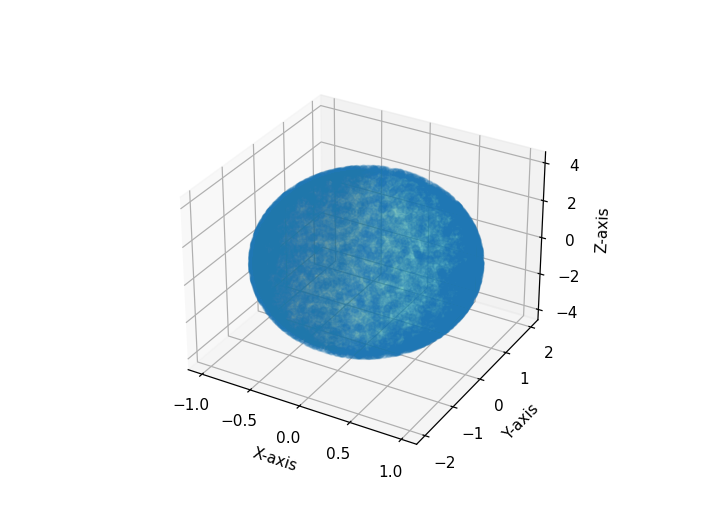

In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch

# Center of the ellipsoid
center = center

# Axes of the ellipsoid (semi-major axis length)
axes = axes

# Rotation matrix
R = inve

# Generate points on the ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = axes[0] * np.outer(np.cos(u), np.sin(v))
y = axes[1] * np.outer(np.sin(u), np.sin(v))
z = axes[2] * np.outer(np.ones_like(u), np.cos(v))

# Transform the points using the rotation matrix
for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center

# Plot the ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2],alpha=0.1)
ax.plot_surface(x, y, z, color='c', alpha=0.3)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()